## Title: Global temperature anamoly analysis with Xarray, Dask, and GeoPandas

### Description:
This Jupyter notebook serves as a project template for analyzing climate data using Xarray, Dask, and GeoPandas. The project involves loading climate data from a NetCDF file, performing various operations, calculating climatologies, and visualizing the results on maps. It also demonstrates the use of Dask for parallel computing to handle large datasets efficiently. It also tries to compare the computational time with and without Dask.

### Dependencies:
xarray, dask, geopandas, matplotlib, cartopy, netCDF4

### Data Source:
The climate data used in this project is sourced from the GISS Surface Temperature Analysis (GISTEMP) dataset provided
by the National Aeronautics and Space Administration (NASA). The dataset contains monthly surface air temperature
anomalies on a global grid with a spatial resolution of 2°x2° and covers the period from 1991 to 2020.

### Workflow Steps:
1. Mount Google Drive and navigate to the dataset folder.
2. Install necessary dependencies using pip and import them.
4. Load the NetCDF file containing climate data into an xarray Dataset.
5. Extract and analyze the dimensions, variables, units, and metadata of the dataset.
6. Perform operations using Xarray and Dask.
7. Visualize the data on maps using Cartopy and GeoPandas.
8. Generate climatologies and perform parallel computing tasks using Dask.
9. Create a NetCDF file with Xarray for the computed climatology variable.

### Mount google drive (only if you are using google colab), Install necessary dependencies and load file

In [1]:
# Mount google drive & go to dataset folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install necessary dependencies
!pip install xarray cartopy dask netcdf4 matplotlib geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.2 MB/s eta 0:00:00


In [3]:
# Import necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import geopandas as gpd
import time

In [4]:
# Load the NetCDF file
file_path = "/content/drive/My Drive/XarrayDask/air.2x2.1200.mon.1991-2020.ltm.comb.nc"
dataset = xr.open_dataset(file_path)

# Print the dataset information to check dimensions and variables
print(dataset)

<xarray.Dataset>
Dimensions:             (lat: 90, lon: 180, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 89.0 87.0 85.0 83.0 ... -85.0 -87.0 -89.0
  * lon                 (lon) float32 1.0 3.0 5.0 7.0 ... 355.0 357.0 359.0
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    air                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes: (12/13)
    title:                          GISS Surface Temperature Analysis (GISTEM...
    comments:                       This is the 1200km smoothed combined land...
    platform:                       Analysis
    Source:                         http://data.giss.nasa.gov/gistemp/ source...
    Documentation:                  http://www.esrl.noaa.gov/psd/data/gridded...
    references:                     http://www.esrl.noaa.gov/ps

/usr/local/lib/python3.10/dist-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


### Check the Dataset

In [5]:
# More information on the loaded data

# Get the units
print("\nUnits of each variable:")                                                # Print units of each variable
for var_name in dataset.variables:
    variable = dataset[var_name]
    if 'units' in variable.attrs:
        units = variable.attrs['units']
    else:
        units = "No units specified"
    print(f"{var_name}: {units}")

# Get the extent
print("\nMinimum and maximum values of each variable:")                           # Find and print minimum and maximum values of each variable
for var_name in dataset.variables:
    variable = dataset[var_name]
    if hasattr(variable, 'dims'):
        minimum = variable.min().values
        maximum = variable.max().values
        print(f"{var_name}: Minimum = {minimum}, Maximum = {maximum}")


Units of each variable:
lat: degrees_north
lon: degrees_east
time: No units specified
climatology_bounds: No units specified
air: degC
valid_yr_count: No units specified

Minimum and maximum values of each variable:
lat: Minimum = -89.0, Maximum = 89.0
lon: Minimum = 1.0, Maximum = 359.0
time: Minimum = 0001-01-01 00:00:00, Maximum = 0001-12-01 00:00:00
climatology_bounds: Minimum = 1991-01-01T00:00:00.000000000, Maximum = 2020-12-01T00:00:00.000000000
air: Minimum = -3.3021645545959473, Maximum = 4.58456563949585
valid_yr_count: Minimum = 0.0, Maximum = 30.0


In [6]:
# Extract the necessary variables
lat = dataset['lat'][:]                                                           # Use Xarray to Extract Necessary Variables
lon = dataset['lon'][:]
air = dataset['air']

# Print the dimensions of the 'air' variable
print('Dimensions of lat :', lat.dims)
print('Dimensions of lon :', lon.dims)
print('Dimensions of air :', air.dims)                                            # 'air' is air temperature anomaly

Dimensions of lat : ('lat',)
Dimensions of lon : ('lon',)
Dimensions of air : ('time', 'lat', 'lon')


In [7]:
# Dask operations

# Convert the 'air' variable to a dask array
air_dask = da.from_array(air, chunks='auto')                                      # Dask array

chunk_sizes = air_dask.chunks                                                     # Check the chunk sizes of the Dask array
print("Chunk sizes:", chunk_sizes)

print(type(air_dask))                                                             # Check the dask_array type

Chunk sizes: ((12,), (90,), (180,))
<class 'dask.array.core.Array'>


In [8]:
# Lazy loading (special property of Dask)
print("\nAir variable metadata (lazy loading):")                                  # Display only metadata without loading data
print(air_dask)


Air variable metadata (lazy loading):
dask.array<array, shape=(12, 90, 180), dtype=float32, chunksize=(12, 90, 180), chunktype=xarray.DataArray>


### Plotting

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


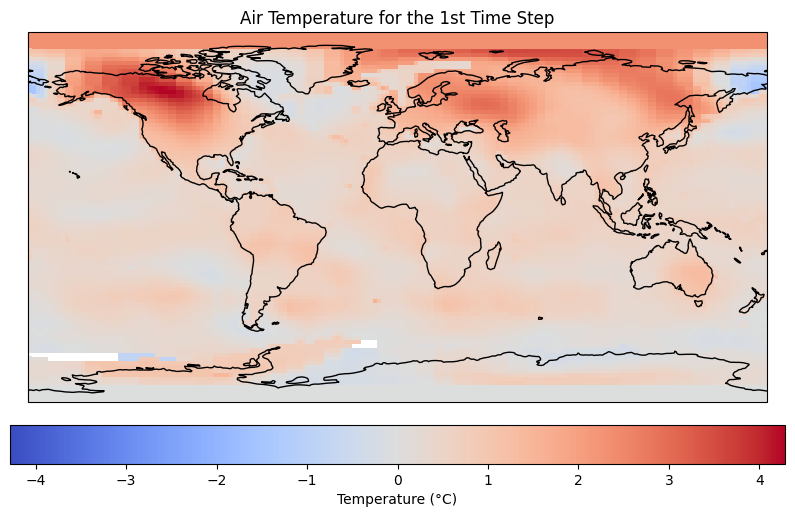

In [9]:
# Plotting

# Plot the air variable for the first time step using Xarray with a map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
temperature = air.isel(time=0)                                                    # Return data along the specified dimension.
im = temperature.plot(transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)
ax.coastlines()
plt.title('Air Temperature for the 1st Time Step')
plt.colorbar(im, label='Temperature (°C)', orientation='horizontal', pad=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

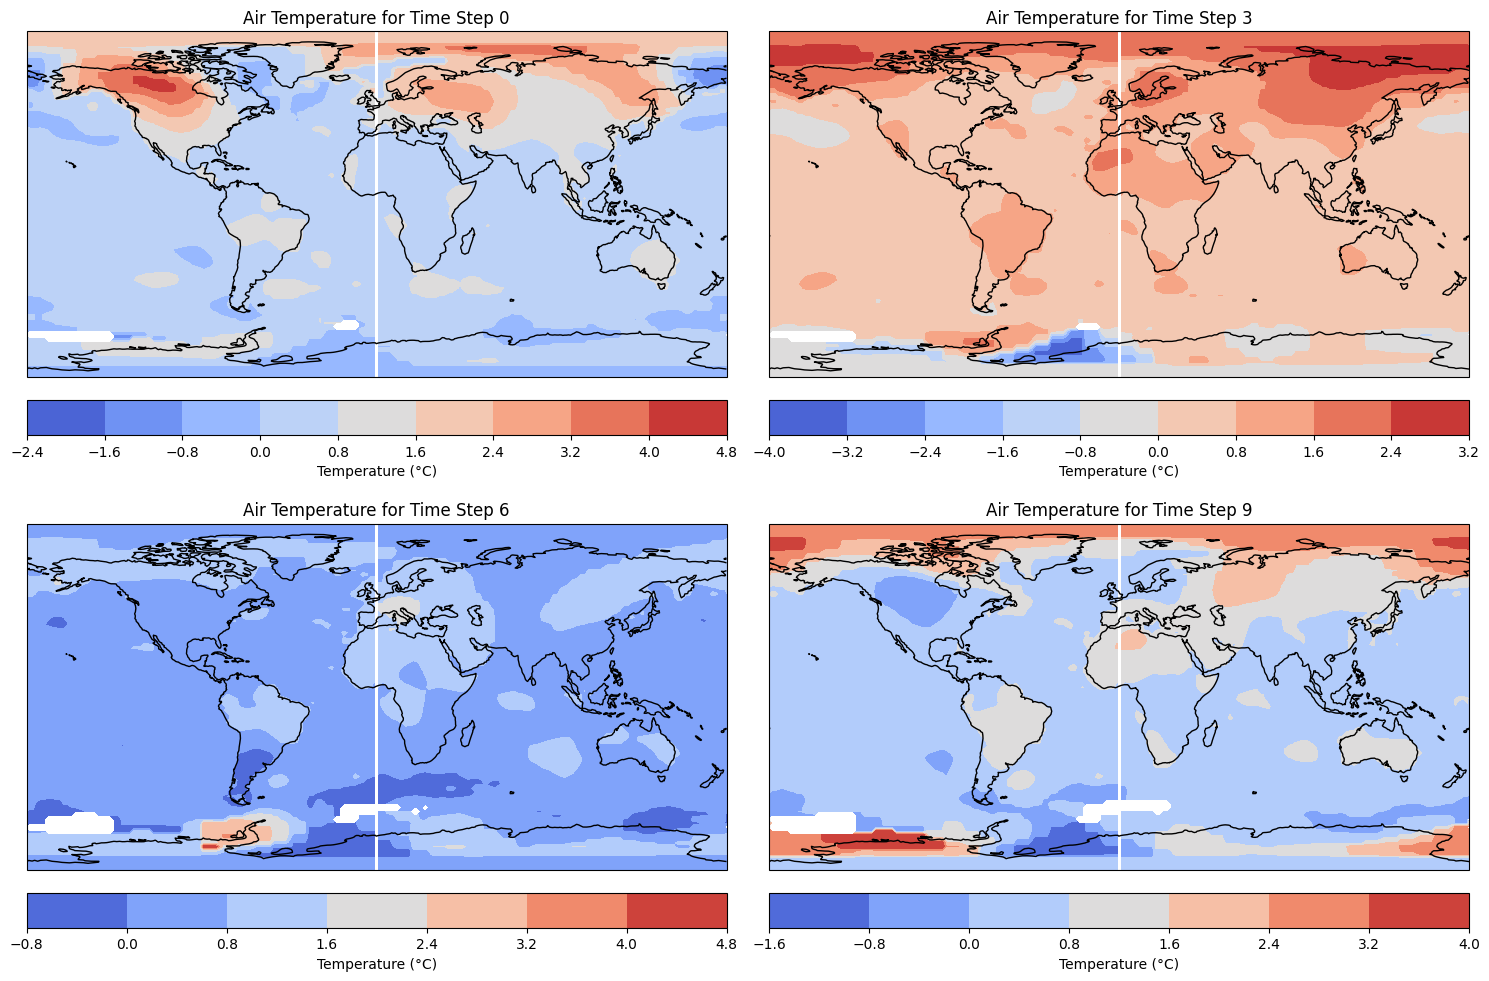

In [10]:
# Plot the first four time steps in subplots

plt.figure(figsize=(15, 10))                                                      # Create a new figure

for i in range(4):
    ax = plt.subplot(2, 2, i+1, projection=ccrs.PlateCarree())                    # Create a subplot with PlateCarree projection
    plt.contourf(lon, lat, air.isel(time=i*3), transform=ccrs.PlateCarree(), cmap='coolwarm')  # Plot air temperature
    plt.colorbar(label='Temperature (°C)', orientation='horizontal', pad=0.05)
    plt.title(f'Air Temperature for Time Step {i*3}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    ax.coastlines()

plt.tight_layout()                                                                # Adjust layout to prevent overlap
plt.show()

<ipython-input-14-18efd930591e>:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


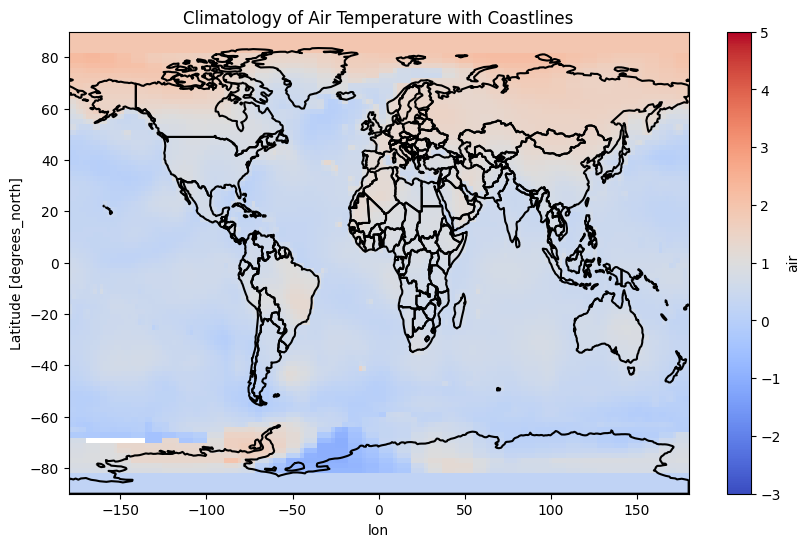

In [14]:
# Plotting with Geopandas

# Calculate the climatology (mean over all timestamps) and Plot

climatology = dataset.mean(dim='time')                                            # Using Xarray
# Adjust the longitude coordinates to range from -180 to 180
climatology = climatology.assign_coords(lon=(climatology.lon + 180) % 360 - 180)  # this is required to allign both our data and geopanda's map coordinates.
climatology = climatology.sortby('lon')

# Plot only the coastlines using GeoPandas
plt.figure(figsize=(10, 6))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coastlines = world.boundary.plot(ax=plt.gca(), color='black')

climatology['air'].plot.imshow(ax=plt.gca(), cmap='coolwarm', vmin=-3, vmax=5)    # Plot the climatology on top

plt.xlim(-180, 180)                                                               # Adjust the bounding box to cover the entire globe
plt.ylim(-90, 90)

#plt.colorbar(label='Temperature (°C)', orientation='horizontal', pad=0.05)

plt.title('Climatology of Air Temperature with Coastlines')
plt.show()

### Check computational time with Dask

In [15]:
# Comparison: time taken with and without Dask operation  (Smaller compuatation)

# Define the threshold for temperature
threshold = 20  # Example threshold

# Without Dask
start_time = time.time()
filtered_data_xarray = air.where(air > threshold, drop=True)
end_time = time.time()
time_xarray = end_time - start_time

# With Dask
# Specify chunks based on the size of the array
chunk_size = (1, air.shape[1], air.shape[2])
air_dask = da.from_array(air, chunks=chunk_size)

# Define a function to filter data using Dask
def filter_data(chunk):
    return da.where(chunk > threshold, chunk, 0)

start_time = time.time()
filtered_data_dask = air_dask.map_blocks(filter_data).compute()
end_time = time.time()
time_dask = end_time - start_time

# Compare the time taken
print("Time taken without Dask:", time_xarray)
print("Time taken with Dask:", time_dask)

Time taken without Dask: 0.019313573837280273
Time taken with Dask: 0.8370671272277832


In [17]:
# Comparison: time taken with and without Dask operation  (Bigger compuatation)

air_first_time_step = ((air.isel(time=0)) ** 8)                                   # Select the first time step
                                                                                  # Deliberately did this computation (to the power 8), for increasing the complexity
def prime_factors(n):                                                             # Define a function to find prime factors
    factors = []
    divisor = 2
    while divisor <= n:
        if n % divisor == 0:
            factors.append(divisor)
            n = n // divisor
        else:
            divisor += 1
    return np.array(factors) if factors else np.array([1])

# Without Dask
start_time = time.time()
prime_factors_xarray = np.vectorize(prime_factors)(air_first_time_step.values)
end_time = time.time()
time_xarray = end_time - start_time

# With Dask
air_dask = da.from_array(air_first_time_step, chunks=air_first_time_step.shape)
start_time = time.time()
prime_factors_dask = np.vectorize(prime_factors)(air_dask.compute())
end_time = time.time()
time_dask = end_time - start_time

# Compare the time taken
print("Time taken without Dask:", time_xarray)
print("Time taken with Dask:", time_dask)

Time taken without Dask: 3.6145052909851074
Time taken with Dask: 2.592710256576538


### Save the climatological variable as NetCDF file

In [19]:
# Define the output file path
output_file_path = "/content/drive/My Drive/XarrayDask/climatology.nc"

# Write the climatology variable to a NetCDF file
climatology.to_netcdf(output_file_path)

print(f"Climatology data has been saved to: {output_file_path}")


Climatology data has been saved to: /content/drive/My Drive/XarrayDask/climatology.nc


In [20]:
#Open the saved NetCDF file
climatology_data = xr.open_dataset(output_file_path)

# Print the contents of the dataset
print("Contents of the dataset:")
print(climatology_data)

# Print the dimensions of the dataset
print("\nDimensions of the dataset:")
print(climatology_data.dims)

Contents of the dataset:
<xarray.Dataset>
Dimensions:         (lat: 90, lon: 180)
Coordinates:
  * lat             (lat) float32 89.0 87.0 85.0 83.0 ... -85.0 -87.0 -89.0
  * lon             (lon) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables:
    air             (lat, lon) float32 ...
    valid_yr_count  (lat, lon) float32 ...

Dimensions of the dataset:
Frozen({'lat': 90, 'lon': 180})


In [ ]:
# Thanks for checking out.